In [2]:
import pandas as pd
import os
from pandas import ExcelWriter
from pandas import ExcelFile

import matplotlib.pyplot as plt

In [3]:
#doesn't work, main data file has multiple worksheets
# csvpath = os.path.join("..", "member_info.csv")
# df1=pd.read_csv(csvpath)
# df1.head()

In [4]:
#import xlsx and read each worksheet as a separate df
csvpath = os.path.join("..", "member_info.xlsx")
xlsx = pd.ExcelFile(csvpath)
gup_members_df = pd.read_excel(xlsx, 'Gup Members')
gup_tests_df = pd.read_excel(xlsx, 'Gup Tests')
dan_members_df = pd.read_excel(xlsx, 'Dan Members')
dan_promotion_df = pd.read_excel(xlsx, 'Dan Promotion')
studio_df = pd.read_excel(xlsx, 'Studio')

In [5]:
dan_members_df.head()

,ID,Region,Date of Birth,Expiration Date,Zip Code,Dan Level,Studio,1st Degree,2nd Degree,3rd Degree,4th Degree,4th Master
0,D14430,9.0,1961-03-20,2022-12-31 00:00:00,06410,1,S1051,2020-07-01,NaT,NaT,NaT,NaT
1,D14399,18.0,1990-10-27,2077-07-07 00:00:00,720,1,S1533,2020-07-01,NaT,NaT,NaT,NaT
2,D14427,9.0,1996-12-01,2022-12-31 00:00:00,12180,1,S1909,2020-07-01,NaT,NaT,NaT,NaT
3,D14397,18.0,1997-08-27,2025-12-31 00:00:00,00612,1,S1474,2020-07-01,NaT,NaT,NaT,NaT
4,D14439,9.0,2002-10-21,2022-12-31 00:00:00,6489,1,S1126,2020-07-01,NaT,NaT,NaT,NaT


In [6]:
#removes rows where 'Date of Birth' was NaN
dan_members_df['Date of Birth']=pd.to_datetime(dan_members_df['Date of Birth'])
dan2_df=dan_members_df.dropna(subset=['Date of Birth'])
dan2_df.head()

,ID,Region,Date of Birth,Expiration Date,Zip Code,Dan Level,Studio,1st Degree,2nd Degree,3rd Degree,4th Degree,4th Master
0,D14430,9.0,1961-03-20,2022-12-31 00:00:00,06410,1,S1051,2020-07-01,NaT,NaT,NaT,NaT
1,D14399,18.0,1990-10-27,2077-07-07 00:00:00,720,1,S1533,2020-07-01,NaT,NaT,NaT,NaT
2,D14427,9.0,1996-12-01,2022-12-31 00:00:00,12180,1,S1909,2020-07-01,NaT,NaT,NaT,NaT
3,D14397,18.0,1997-08-27,2025-12-31 00:00:00,00612,1,S1474,2020-07-01,NaT,NaT,NaT,NaT
4,D14439,9.0,2002-10-21,2022-12-31 00:00:00,6489,1,S1126,2020-07-01,NaT,NaT,NaT,NaT


In [9]:
#pulls year from 'Date of Birth'
dan2_df['Birthday']=pd.DatetimeIndex(dan2_df['Date of Birth']).year
dan2_df['Age']=2020-dan2_df['Birthday']
dan2_df.head()

c:\users\belac\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\belac\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,ID,Region,Date of Birth,Expiration Date,Zip Code,Dan Level,Studio,1st Degree,2nd Degree,3rd Degree,4th Degree,4th Master,Birthday,Age
0,D14430,9.0,1961-03-20,2022-12-31 00:00:00,06410,1,S1051,2020-07-01,NaT,NaT,NaT,NaT,1961,59
1,D14399,18.0,1990-10-27,2077-07-07 00:00:00,720,1,S1533,2020-07-01,NaT,NaT,NaT,NaT,1990,30
2,D14427,9.0,1996-12-01,2022-12-31 00:00:00,12180,1,S1909,2020-07-01,NaT,NaT,NaT,NaT,1996,24
3,D14397,18.0,1997-08-27,2025-12-31 00:00:00,00612,1,S1474,2020-07-01,NaT,NaT,NaT,NaT,1997,23
4,D14439,9.0,2002-10-21,2022-12-31 00:00:00,6489,1,S1126,2020-07-01,NaT,NaT,NaT,NaT,2002,18


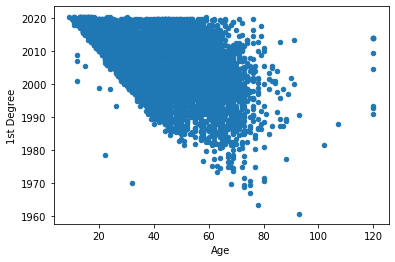

In [10]:
#x-axis is birthday, y-axis is date of receiving first degree.  Want to change x axis to age
dan2_df.plot(kind='scatter', x='Age', y='1st Degree')

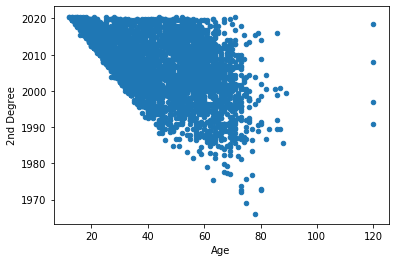

In [11]:
dan2_df.plot(kind='scatter', x='Age', y='2nd Degree')

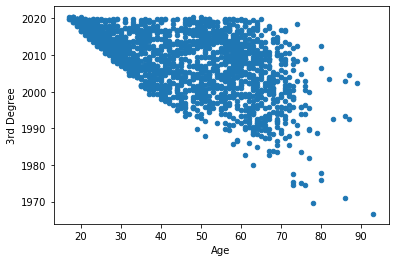

In [32]:
dan2_df.plot(kind='scatter', x='Age', y='3rd Degree')

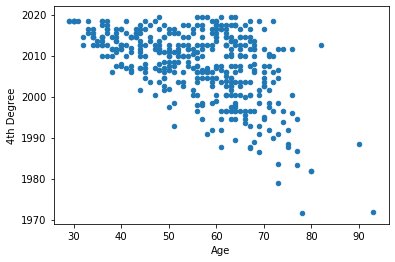

In [33]:
dan2_df.plot(kind='scatter', x='Age', y='4th Degree')

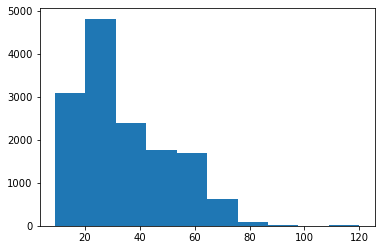

In [34]:
#histogram of number of black belts of each age
x=dan2_df['Age']
plt.hist(x)
plt.show()

c:\users\belac\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\belac\appdata\local\programs\python\python37-32\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\users\belac\appdata\local\programs\python\python37-32\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<function matplotlib.pyplot.show(*args, **kw)>

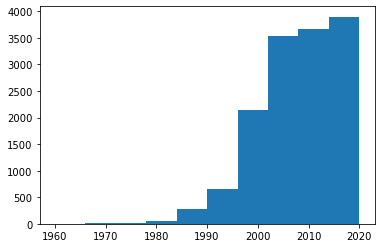

In [27]:
#shows number of new black belts tested each year
dan2_df['1st']=pd.DatetimeIndex(dan2_df['1st Degree']).year
x=dan2_df['1st']
plt.hist(x)
plt.show

c:\users\belac\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\belac\appdata\local\programs\python\python37-32\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\users\belac\appdata\local\programs\python\python37-32\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<function matplotlib.pyplot.show(*args, **kw)>

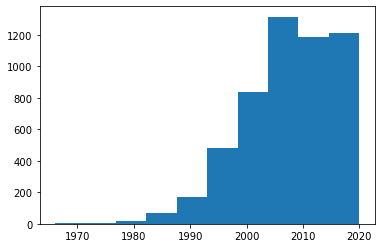

In [35]:
#shows number of 2nd degrees tested each year
dan2_df['2nd']=pd.DatetimeIndex(dan2_df['2nd Degree']).year
x=dan2_df['2nd']
plt.hist(x)
plt.show

c:\users\belac\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<function matplotlib.pyplot.show(*args, **kw)>

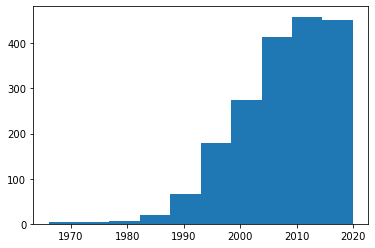

In [36]:
#shows number of 3rd degrees tested each year
dan2_df['3rd']=pd.DatetimeIndex(dan2_df['3rd Degree']).year
x=dan2_df['3rd']
plt.hist(x)
plt.show

c:\users\belac\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<function matplotlib.pyplot.show(*args, **kw)>

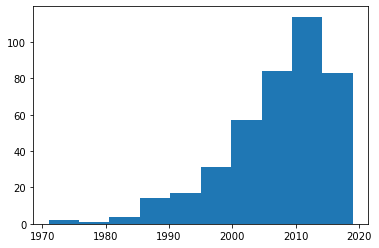

In [37]:
#shows number of 4th degrees tested each year
dan2_df['4th']=pd.DatetimeIndex(dan2_df['4th Degree']).year
x=dan2_df['4th']
plt.hist(x)
plt.show

In [42]:
dan_studio_merge=pd.merge(dan_members_df,studio_df, on='Studio')
dan_studio_merge.head()

,ID,Region_x,Date of Birth,Expiration Date,Zip Code_x,Dan Level,Studio,1st Degree,2nd Degree,3rd Degree,4th Degree,4th Master,Region_y,Studio/Club,Zip Code_y,Country
0,D14430,9.0,1961-03-20,2022-12-31 00:00:00,06410,1,S1051,2020-07-01,NaT,NaT,NaT,NaT,9.0,S1051,06450-0000,USA
1,D14432,9.0,2003-01-04,2022-12-31 00:00:00,6450,1,S1051,2020-07-01,NaT,NaT,NaT,NaT,9.0,S1051,06450-0000,USA
2,D14431,9.0,2004-02-09,2022-12-31 00:00:00,6450,1,S1051,2020-07-01,NaT,NaT,NaT,NaT,9.0,S1051,06450-0000,USA
3,D14428,9.0,2007-07-01,2022-12-31 00:00:00,06450,1,S1051,2020-07-01,NaT,NaT,NaT,NaT,9.0,S1051,06450-0000,USA
4,D14429,9.0,2009-07-31,2022-12-31 00:00:00,6037,1,S1051,2020-07-01,NaT,NaT,NaT,NaT,9.0,S1051,06450-0000,USA
